In [1]:
#https://github.com/nhamlv-55/CFI_NNs/blob/master/MNIST_toy/Experiment-Feb28-xujie-Copy1.ipynb

from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print(use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])


True


In [2]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Train/Load model


In [3]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'FFN19-17-24'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNN14-28-29'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
#                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

 -accuracy 0.9042-


#### Compute all patterns in the training set, and put them into corresponding labels

In [4]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
    
    

layers = ['fc1', 'fc2', 'fc3', 'fc4']
# layers = ['conv1', 'conv2','fc1', 'fc2']

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)



root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [5]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

In [6]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    


all_stable_relus = []

all_alpha_patterns = {"model": LOADPATH}

write_log = True
if write_log:
    ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
    ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
epsilon_to_patterns = dict()
for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
    alpha_patterns = {}
    label_to_most_common_pattern = dict()
    for label in all_patterns.label2patterns:
#     for label in [0,2,8]:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)

        occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
        most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

        #print("most common pattern: {}".format(most_common_pattern) )
        
        pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
        #print("pattern_indices: {}".format(pattern_indices))
        label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
        relu_sum = np.sum(patterns, axis = 0).squeeze()
        
        print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
#         print("relu_sum, layer-1 ", relu_sum[:256])
#         print("relu_sum, layer-2 ", relu_sum[256:384])
#         print("relu_sum, layer-3 ", relu_sum[384:448])
        print("relu_sum, prediction", relu_sum[448:458])
#         print("relu_sum", relu_sum[-10:])
        
        non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
        active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
        print("non active neurons: ", non_active_neurons)
        print("active neurons: ", active_neurons)

        stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                     np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                    axis = 1
                                    ).squeeze()
        neuro_idx = patterns.shape[1] - 10 + label
        if neuro_idx not in stable_idx:
            print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
            stable_idx = np.append(stable_idx, neuro_idx)
        stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print("unique patterns:", unique_patterns)
        print()
        print("Label is ", label)
        print("Stable ReLUs", stable_idx)
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
#         print("most prominent pattern", np.argmax(freq), alpha_p)
#         print("alpha_p is ", alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                 "active_neurons": active_neurons[0],
                                 "non_active_neurons": non_active_neurons[0],
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
    
#         print("pattern frequency:", freq)
        print("primary pattern coverage: ", freq.max()/freq.sum(),)

        if write_log:
            ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
    epsilon_to_patterns[epsilon] = label_to_most_common_pattern
json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
if write_log:
    ReLU_exp_log.close()
    json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
    ReLU_exp_json.close()

(5923, 458)
threshold:  0.5923 5922.4077
relu_sum, prediction [5685    0   29   15   11   77   48   11   43    4]
non active neurons:  (array([257, 267, 288, 338, 343, 374, 375, 392, 401, 403, 414, 418, 449],
      dtype=int64),)
active neurons:  (array([ 19,  70, 142, 238, 258, 259, 260, 265, 275, 285, 287, 295, 302,
       307, 323, 329, 339, 340, 346, 347, 349, 352, 360, 365, 369, 380,
       396, 406, 417, 420, 423, 424, 426, 429, 434], dtype=int64),)
WARN: neuro_idx = 448 for label 0 is not stable, let's include it anyway
unique patterns: [[ True  True  True  True False  True  True  True  True False  True  True
   True False  True  True  True  True  True False  True  True False  True
   True  True  True  True  True  True False False  True False  True False
  False  True False  True False  True  True  True  True  True  True False
  False]
 [ True  True  True  True False  True  True  True  True False  True  True
   True False  True  True  True  True  True False  True  True False  Tr

threshold:  0.5918 5917.4082
relu_sum, prediction [  57   31   44    1   68   85 5606    1   25    0]
non active neurons:  (array([257, 267, 288, 325, 338, 343, 345, 374, 375, 392, 401, 403, 411,
       414, 418, 444, 457], dtype=int64),)
active neurons:  (array([ 39,  58, 142, 145, 179, 196, 207, 210, 220, 238, 253, 258, 259,
       273, 275, 285, 295, 297, 299, 302, 307, 310, 314, 315, 316, 321,
       323, 329, 333, 336, 339, 340, 346, 347, 349, 356, 357, 358, 360,
       365, 366, 369, 371, 378, 379, 380, 394, 395, 404, 405, 406, 409,
       410, 420, 423, 431, 434, 441], dtype=int64),)
WARN: neuro_idx = 454 for label 6 is not stable, let's include it anyway
unique patterns: [[ True  True  True  True  True  True  True  True  True  True  True False
   True  True False  True  True  True False  True  True  True  True  True
   True  True  True  True  True  True False  True  True  True False  True
   True False False  True  True  True  True  True  True  True  True  True
   True  True Fa

threshold:  3.371 6738.629000000001
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([257, 267, 319, 325, 326, 338, 343, 345, 374, 375, 386, 392, 401,
       403, 411, 414, 418, 444, 448], dtype=int64),)
active neurons:  (array([  1,   6,  12,  13,  17,  26,  31,  33,  39,  49,  58,  65,  66,
        75,  87,  91,  96,  97,  98,  99, 112, 145, 157, 158, 162, 167,
       176, 180, 189, 194, 196, 207, 220, 239, 249, 256, 258, 259, 260,
       268, 270, 271, 272, 273, 275, 277, 284, 290, 295, 297, 310, 312,
       314, 315, 317, 318, 321, 323, 328, 329, 333, 336, 339, 341, 346,
       356, 357, 358, 363, 364, 366, 368, 369, 371, 377, 378, 379, 380,
       387, 389, 390, 394, 399, 400, 404, 408, 409, 416, 419, 420, 424,
       428, 431, 433, 435, 438, 441, 443], dtype=int64),)
WARN: neuro_idx = 449 for label 1 is not stable, let's include it anyway
unique patterns: [[False False  True ... False False False]
 [ True False  True ... False F

threshold:  2.9210000000000003 5839.079000000001
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([257, 267, 288, 319, 325, 343, 345, 372, 374, 375, 386, 392, 401,
       403, 411, 414, 418, 444, 451], dtype=int64),)
active neurons:  (array([ 54,  55,  58,  66,  84, 115, 129, 143, 145, 155, 196, 220, 223,
       228, 256, 258, 261, 273, 275, 285, 286, 295, 296, 298, 299, 302,
       306, 307, 310, 314, 316, 321, 323, 333, 336, 339, 341, 346, 349,
       351, 356, 357, 358, 360, 377, 378, 379, 394, 395, 404, 405, 407,
       409, 417, 420, 422, 423, 425, 426, 431, 436, 441], dtype=int64),)
WARN: neuro_idx = 452 for label 4 is not stable, let's include it anyway
unique patterns: [[False False  True ... False False False]
 [False  True  True ... False False False]
 [ True False  True ... False False False]
 ...
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]
 [ True  True  True ... False False  True]

threshold:  2.9745 5946.025500000001
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 343, 345, 372, 374, 375, 392, 401, 403, 411, 414, 418],
      dtype=int64),)
active neurons:  (array([ 12,  54,  58,  65,  66,  87,  98, 112, 115, 138, 143, 155, 189,
       196, 220, 223, 258, 259, 273, 275, 277, 282, 283, 285, 286, 295,
       298, 299, 306, 307, 308, 314, 321, 323, 329, 333, 334, 336, 339,
       341, 346, 349, 351, 359, 360, 367, 369, 377, 380, 389, 404, 405,
       407, 417, 422, 426, 436], dtype=int64),)
WARN: neuro_idx = 457 for label 9 is not stable, let's include it anyway
unique patterns: [[False False  True ...  True  True False]
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]]

Label is  9
Stable ReLUs [12, 54, 58, 65, 66, 87, 98, 112, 115, 1

threshold:  5.8420000000000005 5836.158
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([257, 267, 288, 319, 325, 326, 343, 345, 372, 374, 375, 386, 392,
       401, 403, 411, 414, 418, 444, 451], dtype=int64),)
active neurons:  (array([ 13,  51,  54,  55,  58,  65,  66,  84,  98, 107, 115, 129, 143,
       145, 155, 179, 196, 198, 200, 219, 220, 223, 228, 248, 256, 258,
       261, 273, 275, 277, 285, 286, 295, 296, 298, 299, 302, 306, 307,
       308, 310, 314, 316, 321, 323, 329, 333, 334, 336, 339, 340, 341,
       346, 347, 349, 351, 353, 356, 357, 358, 360, 361, 369, 377, 378,
       379, 394, 395, 397, 404, 405, 407, 409, 417, 419, 420, 422, 423,
       425, 426, 431, 436, 441], dtype=int64),)
WARN: neuro_idx = 452 for label 4 is not stable, let's include it anyway
unique patterns: [[False  True  True ... False False False]
 [False  True  True ... False False False]
 [ True False False ... False False False]
 ...
 [ True  True

threshold:  5.949 5943.051
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 288, 343, 345, 372, 374, 375, 386, 392, 401, 403, 411,
       414, 418], dtype=int64),)
active neurons:  (array([  8,  12,  54,  55,  58,  65,  66,  87,  96,  98, 107, 112, 115,
       129, 138, 143, 155, 170, 189, 196, 201, 220, 223, 229, 258, 259,
       264, 273, 275, 277, 282, 283, 285, 286, 295, 298, 299, 306, 307,
       308, 312, 314, 321, 323, 329, 330, 332, 333, 334, 336, 339, 341,
       344, 346, 349, 351, 357, 358, 359, 360, 365, 367, 369, 377, 380,
       389, 391, 395, 404, 405, 407, 417, 422, 426, 431, 434, 436, 439,
       442], dtype=int64),)
WARN: neuro_idx = 457 for label 9 is not stable, let's include it anyway
unique patterns: [[False  True  True ...  True  True False]
 [False  True  True ...  True  True  True]
 [ True False False ... False False False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  Tru

threshold:  29.79 5928.21
relu_sum, prediction [  72  103 5157  106  116   22  126   98  127   31]
non active neurons:  (array([257, 267, 288, 305, 319, 325, 326, 343, 345, 372, 374, 375, 385,
       386, 392, 401, 403, 411, 414, 418, 444, 453], dtype=int64),)
active neurons:  (array([ 12,  17,  30,  39,  47,  58,  65,  75,  76,  97,  99, 112, 142,
       143, 145, 179, 180, 194, 196, 202, 214, 220, 242, 249, 258, 259,
       260, 270, 271, 273, 275, 277, 283, 286, 290, 293, 295, 297, 299,
       302, 307, 310, 314, 315, 321, 323, 329, 333, 339, 346, 347, 352,
       355, 357, 358, 360, 363, 364, 365, 366, 368, 369, 371, 379, 380,
       394, 395, 400, 404, 406, 409, 410, 420, 422, 423, 428, 431, 434,
       438, 440, 441], dtype=int64),)
WARN: neuro_idx = 450 for label 2 is not stable, let's include it anyway
unique patterns: [[False False False ... False False False]
 [False  True False ... False False False]
 [False  True  True ... False False False]
 ...
 [ True  True  True ... Fal

threshold:  27.105 5393.8949999999995
relu_sum, prediction [  93   59   37  228   96 4560  113   34  128   73]
non active neurons:  (array([257, 267, 325, 338, 343, 345, 372, 374, 375, 385, 392, 401, 403,
       411, 414, 418, 444], dtype=int64),)
active neurons:  (array([ 17,  27,  31,  41,  56,  58,  66,  70,  75,  87,  88,  96,  97,
       112, 138, 142, 143, 145, 157, 167, 173, 179, 191, 194, 196, 220,
       223, 238, 256, 258, 259, 260, 261, 265, 270, 272, 275, 277, 283,
       285, 286, 287, 290, 295, 298, 301, 302, 307, 317, 318, 321, 323,
       329, 336, 339, 340, 346, 347, 349, 351, 352, 357, 358, 360, 365,
       366, 369, 371, 377, 378, 380, 382, 390, 393, 394, 395, 396, 397,
       399, 400, 404, 406, 408, 417, 419, 420, 422, 423, 424, 426, 429,
       431, 433, 434], dtype=int64),)
WARN: neuro_idx = 453 for label 5 is not stable, let's include it anyway
unique patterns: [[False False  True ...  True False False]
 [False  True  True ...  True False  True]
 [False  True  T

threshold:  29.255 5821.745
relu_sum, prediction [  26  144   81  185   47  206   52   13 4966  131]
non active neurons:  (array([257, 267, 279, 288, 305, 325, 326, 338, 343, 345, 354, 372, 374,
       375, 386, 392, 401, 403, 411, 414, 418, 444, 448, 455], dtype=int64),)
active neurons:  (array([  6,  12,  13,  17,  27,  30,  31,  32,  39,  41,  49,  51,  55,
        56,  58,  65,  66,  69,  70,  74,  75,  80,  83,  84,  85,  87,
        88,  96,  97,  98, 107, 110, 112, 115, 119, 122, 129, 138, 142,
       143, 145, 157, 166, 167, 170, 173, 179, 185, 188, 189, 191, 194,
       195, 196, 198, 201, 202, 207, 217, 220, 223, 229, 230, 231, 234,
       238, 239, 240, 242, 248, 249, 256, 258, 259, 260, 261, 270, 271,
       272, 273, 274, 275, 277, 282, 283, 285, 286, 287, 290, 295, 297,
       298, 299, 302, 306, 307, 308, 310, 312, 316, 317, 318, 321, 323,
       329, 333, 336, 339, 340, 341, 346, 347, 349, 352, 355, 356, 357,
       358, 360, 363, 364, 365, 366, 368, 369, 371, 377, 379,

threshold:  67.42 6674.58
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([ 28,  68, 126, 161, 244, 257, 266, 267, 279, 288, 292, 319, 325,
       326, 338, 343, 345, 374, 375, 385, 386, 392, 401, 403, 411, 414,
       418, 444, 448, 450, 451, 452, 453, 454, 455, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,  12,  13,  14,  17,  24,  26,  31,  33,  38,  39,
        49,  51,  52,  57,  58,  61,  63,  64,  65,  66,  67,  74,  75,
        76,  79,  80,  81,  84,  87,  91,  96,  97,  98,  99, 103, 105,
       112, 113, 119, 124, 138, 143, 145, 151, 153, 157, 158, 160, 162,
       166, 167, 169, 170, 176, 180, 185, 188, 189, 191, 194, 196, 201,
       202, 207, 212, 217, 220, 229, 230, 233, 237, 239, 240, 249, 250,
       256, 258, 259, 260, 261, 265, 268, 270, 271, 272, 273, 275, 277,
       282, 283, 284, 286, 290, 295, 297, 298, 301, 304, 308, 310, 312,
       314, 315, 316, 317, 318, 320, 321, 323, 324, 328, 329, 331, 3

threshold:  61.31 6069.69
relu_sum, prediction [  22   42  156 5277    2  323   25   85  144   55]
non active neurons:  (array([ 68, 126, 225, 257, 267, 279, 288, 305, 319, 325, 326, 338, 343,
       345, 370, 372, 374, 375, 385, 386, 392, 401, 403, 411, 414, 418,
       444, 448, 449, 452, 454, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,   7,  12,  17,  27,  30,  31,  32,  41,  49,  56,
        58,  63,  65,  66,  69,  74,  75,  82,  83,  85,  87,  88,  96,
        97,  98, 112, 132, 138, 140, 143, 145, 149, 157, 166, 167, 170,
       174, 180, 185, 189, 194, 196, 201, 202, 205, 206, 217, 220, 229,
       234, 243, 249, 256, 258, 259, 260, 261, 264, 265, 270, 272, 274,
       275, 277, 280, 283, 285, 286, 290, 295, 298, 302, 307, 308, 312,
       317, 318, 321, 322, 323, 324, 329, 330, 331, 333, 334, 335, 336,
       337, 339, 340, 344, 346, 347, 352, 357, 358, 359, 360, 363, 364,
       365, 366, 367, 368, 369, 371, 380, 383, 389, 390, 393, 394, 396,
       397, 399,

threshold:  54.21 5366.79
relu_sum, prediction [  93   59   37  228   96 4560  113   34  128   73]
non active neurons:  (array([225, 257, 267, 279, 288, 325, 338, 343, 345, 372, 374, 375, 385,
       392, 401, 403, 411, 414, 418, 444, 450, 455], dtype=int64),)
active neurons:  (array([  9,  12,  17,  27,  31,  41,  56,  58,  63,  66,  70,  74,  75,
        83,  85,  87,  88,  96,  97, 100, 110, 112, 127, 138, 142, 143,
       145, 157, 167, 170, 172, 173, 179, 189, 191, 194, 196, 217, 220,
       223, 234, 238, 239, 240, 249, 256, 258, 259, 260, 261, 265, 270,
       272, 274, 275, 277, 283, 285, 286, 287, 290, 295, 298, 301, 302,
       306, 307, 317, 318, 321, 323, 329, 334, 336, 339, 340, 344, 346,
       347, 349, 351, 352, 357, 358, 360, 365, 366, 369, 371, 377, 378,
       380, 382, 390, 393, 394, 395, 396, 397, 399, 400, 404, 405, 406,
       408, 409, 417, 419, 420, 422, 423, 424, 426, 429, 431, 433, 434,
       439], dtype=int64),)
WARN: neuro_idx = 453 for label 5 is not stab

threshold:  62.65 6202.35
relu_sum, prediction [  31   47   93   28   83   15    1 5789   20  158]
non active neurons:  (array([257, 267, 279, 288, 305, 319, 326, 338, 343, 345, 372, 374, 375,
       386, 401, 403, 411, 414, 418, 444, 448, 449, 451, 453, 454, 456],
      dtype=int64),)
active neurons:  (array([  7,   8,  12,  17,  26,  31,  49,  54,  58,  59,  60,  63,  65,
        66,  70,  74,  75,  82,  86,  87,  96,  98, 107, 112, 115, 124,
       125, 129, 131, 138, 142, 143, 144, 145, 155, 160, 170, 189, 191,
       192, 194, 196, 201, 206, 216, 220, 223, 228, 229, 231, 235, 239,
       248, 258, 259, 260, 264, 265, 270, 272, 273, 275, 276, 277, 282,
       283, 284, 285, 286, 290, 295, 296, 298, 299, 306, 307, 308, 309,
       312, 314, 317, 318, 320, 321, 323, 329, 330, 332, 333, 334, 336,
       339, 341, 344, 346, 349, 350, 359, 360, 361, 365, 367, 369, 377,
       380, 383, 388, 389, 391, 396, 402, 404, 405, 406, 407, 408, 415,
       416, 417, 422, 424, 426, 430, 431, 432, 

threshold:  59.49 5889.51
relu_sum, prediction [  43   21   22   76  249   43   10  247   72 5166]
non active neurons:  (array([257, 267, 288, 305, 319, 325, 326, 338, 343, 345, 372, 374, 375,
       385, 386, 392, 401, 403, 411, 414, 418, 444, 448, 449, 450, 453,
       454], dtype=int64),)
active neurons:  (array([  8,  12,  17,  26,  27,  30,  32,  49,  51,  54,  55,  58,  59,
        60,  63,  65,  66,  70,  74,  75,  76,  80,  84,  87,  89,  96,
        98, 107, 110, 112, 115, 119, 122, 124, 125, 128, 129, 137, 138,
       143, 144, 145, 155, 170, 179, 189, 191, 196, 198, 201, 208, 218,
       219, 220, 223, 224, 228, 229, 231, 234, 238, 239, 247, 248, 258,
       259, 261, 264, 265, 270, 272, 273, 275, 276, 277, 282, 283, 284,
       285, 286, 290, 294, 295, 296, 298, 299, 302, 306, 307, 308, 310,
       312, 314, 317, 318, 320, 321, 323, 329, 330, 332, 333, 334, 336,
       339, 340, 341, 344, 346, 347, 349, 350, 351, 353, 357, 358, 359,
       360, 361, 363, 364, 365, 366, 367,

threshold:  337.1 6404.9
relu_sum, prediction [   1 6519   35   27   10   28    8   22   88    4]
non active neurons:  (array([  0,  28,  34,  35,  36,  48,  68, 126, 161, 225, 226, 244, 257,
       262, 266, 267, 279, 288, 291, 292, 319, 325, 326, 338, 343, 345,
       348, 354, 374, 375, 385, 386, 392, 398, 401, 403, 411, 414, 418,
       444, 448, 450, 451, 452, 453, 454, 455, 456, 457], dtype=int64),)
active neurons:  (array([  1,   5,   6,   7,   9,  12,  13,  14,  16,  17,  22,  24,  25,
        26,  30,  31,  33,  38,  39,  49,  51,  52,  57,  58,  59,  60,
        61,  63,  64,  65,  66,  67,  69,  74,  75,  76,  79,  80,  81,
        83,  84,  87,  91,  94,  96,  97,  98,  99, 103, 105, 106, 107,
       110, 112, 113, 119, 123, 124, 137, 138, 143, 145, 150, 151, 153,
       156, 157, 158, 160, 162, 166, 167, 169, 170, 176, 180, 185, 188,
       189, 191, 192, 194, 196, 201, 202, 207, 212, 217, 220, 223, 224,
       229, 230, 231, 233, 234, 237, 239, 240, 249, 250, 251, 256, 25

threshold:  292.1 5549.9
relu_sum, prediction [  14   22   33    0 5380   12   86    9   42  244]
non active neurons:  (array([ 48, 108, 161, 255, 257, 262, 267, 288, 305, 311, 319, 325, 326,
       338, 343, 345, 372, 374, 375, 386, 392, 401, 403, 411, 414, 418,
       444, 445, 448, 449, 450, 451, 453, 454, 455, 456, 457], dtype=int64),)
active neurons:  (array([  8,  12,  13,  17,  26,  27,  30,  32,  39,  41,  46,  47,  49,
        51,  54,  55,  56,  58,  60,  65,  66,  70,  74,  75,  76,  77,
        80,  81,  84,  86,  87,  88,  89,  93,  95,  96,  97,  98, 104,
       107, 110, 112, 113, 114, 115, 117, 118, 119, 120, 122, 125, 128,
       129, 137, 138, 143, 145, 147, 155, 167, 173, 179, 180, 188, 190,
       191, 192, 195, 196, 197, 198, 199, 200, 201, 203, 207, 208, 210,
       216, 218, 219, 220, 223, 224, 228, 229, 231, 234, 235, 238, 239,
       240, 242, 247, 248, 249, 252, 253, 256, 258, 259, 260, 261, 263,
       270, 271, 273, 275, 276, 277, 282, 283, 284, 285, 286, 28

threshold:  313.25 5951.75
relu_sum, prediction [  31   47   93   28   83   15    1 5789   20  158]
non active neurons:  (array([108, 221, 225, 257, 262, 267, 279, 288, 305, 319, 325, 326, 338,
       343, 345, 370, 372, 374, 375, 385, 386, 392, 401, 403, 411, 414,
       418, 444, 448, 449, 450, 451, 452, 453, 454, 456, 457], dtype=int64),)
active neurons:  (array([  7,   8,   9,  12,  17,  19,  26,  31,  33,  46,  49,  54,  55,
        58,  59,  60,  63,  65,  66,  70,  74,  75,  76,  77,  82,  86,
        87,  88,  89,  96,  98, 102, 106, 107, 112, 115, 118, 124, 125,
       127, 128, 129, 131, 137, 138, 142, 143, 144, 145, 155, 159, 160,
       167, 170, 177, 186, 187, 189, 191, 192, 194, 196, 199, 201, 203,
       206, 208, 212, 213, 216, 218, 220, 223, 224, 228, 229, 231, 234,
       235, 238, 239, 240, 245, 248, 252, 258, 259, 260, 264, 265, 270,
       272, 273, 275, 276, 277, 282, 283, 284, 285, 286, 289, 290, 293,
       294, 295, 296, 298, 299, 306, 307, 308, 309, 310, 312, 

In [7]:
# # LOAD THE AVED ALPHA PATTERNS
# LOAD_PATTERNS = True
# PATTERN_PATH = "relu_exp_data02-20-19.json"
# if LOAD_PATTERNS:
    
#     # Opening JSON file
#     f = open(PATTERN_PATH)

#     # returns JSON object as 
#     # a dictionary
#     data = json.load(f)

#     f.close()
#     print(data)

## Apply delta debugging

In [8]:
import matplotlib.pyplot as plt
from custom_transform import *
from models import MNISTNet
from transforms import TRANSFORMS
from mask import *
import imageio
from utils import generate_gif
import os

# For delta debugging
img_eraser = CustomizeMask(value=-0.4)

# Parameters
THRESHOLD = 0.6
ROOT_FOLDER = "./"
TMP_IMG_FOLDER = os.path.join(ROOT_FOLDER, "test")

RESULT_FOLDER_NAME = "test_gif"
GIF_RESULT = ROOT_FOLDER + RESULT_FOLDER_NAME + "/{}/gif_results/img_{}.gif"
IMG_RESULT = ROOT_FOLDER + RESULT_FOLDER_NAME + "/{}/img_results/img_{}.png"

# Create folders for save all the results, only run once
create_folders = False
if create_folders:
    os.mkdir(ROOT_FOLDER + RESULT_FOLDER_NAME)
    for i in range(10):
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/".format(i))
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/{}".format(i,'gif_results'))
        os.mkdir(ROOT_FOLDER+RESULT_FOLDER_NAME+"/{}/{}".format(i,'img_results'))
# MODEL_PATH = "./cifar10_net_v2.pth"

# epsilon_for_pattern = 0.0001

# We have loaded the dataset already at the beginning

def check_activation(data, label, device, active_neurons_idx, non_active_neurons_idx):
    
    img_pattern = model.get_pattern(data, layers, device, flatten = True)
    img_non_active_neurons = img_pattern[:, non_active_neurons_idx]
    img_active_neurons = img_pattern[:, active_neurons_idx]
    
    return img_non_active_neurons.sum() == 0 and img_active_neurons.sum() == len(active_neurons_idx)

def check_activation_with_pattern(data, label, device, ref_pattern, neuron_for_act_check_idx):
    
    img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    return np.all(img_pattern[:, neuron_for_act_check_idx] == ref_pattern[:, neuron_for_act_check_idx])



def delta_debugging_general_new(img_eraser, model, threshold, img, label, epsilon_for_pattern, check_act_portion=1.0, check_act=True):

    model.eval()
    
    active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["non_active_neurons"]
#     alpha_pattern = all_alpha_patterns[epsilon_for_pattern][label]["alpha_pattern"]
#     stable_idx = all_alpha_patterns[epsilon_for_pattern][label]["stable_idx"]
    org_pattern = model.get_pattern(img[None, :], layers, device, flatten = True)
    
    num_pick = int(check_act_portion * 458)
    neuron_for_act_check_idx = np.random.choice(range(0, 458), num_pick, replace=False)
    assert len(set(neuron_for_act_check_idx)) == num_pick

    
    c, h, w = img.shape

    current_unmasked_pixels = torch.ones((c, h, w))
    
    keep_going = True
    smaller_chunk = True
    get_modified = False

    current_img = img.clone()
    current_pred = None
    current_pred_prob = 1

    prev_img = img.clone()
    prev_pred = None
    prev_pred_prob = 1
    

    img_counter = 0
    img_names = []
    smaller_group_number = None  
#     img_folder = "./gif_img"
    if not os.path.exists(TMP_IMG_FOLDER):
        os.mkdir(TMP_IMG_FOLDER)
    if smaller_chunk:
        smaller_group_number = 2
#         for _ in range(1):

        while keep_going:
#             print("partition: ", smaller_group_number)
            prev_img, prev_pred, prev_pred_prob = current_img, current_pred, current_pred_prob
            
            # save figures for gif
            
            figure = plt.figure()
            plt.title("Pred prob: {}".format(prev_pred_prob))
            plt.imshow(prev_img.reshape(28, 28), cmap="gray")
            img_name = '{}.png'.format(img_counter)
            plt.savefig(os.path.join(TMP_IMG_FOLDER, img_name))
            plt.close(figure)
            img_names.append(img_name)
            img_counter += 1

            pixel_left = int(torch.sum(current_unmasked_pixels[0]).item())
            if smaller_group_number > pixel_left:
                smaller_group_number = pixel_left
            
            try:
                all_new_masks = split_in_smaller_groups(current_unmasked_pixels, smaller_group_number)
            except:
                keep_going = False
                continue
                
            best_group_num = None
            best_pred_prob = 0
                      
            cur_act = None
            for m_idx in range(smaller_group_number):
                new_unmask = all_new_masks[m_idx]
                new_img = img_eraser(img, new_unmask)                
                new_extend_img = new_img[None, :]
                with torch.no_grad():
                    output = model(new_extend_img.to(device))
                    same_activation = True
                    if check_act:
                        same_activation = check_activation(new_extend_img, label, device, active_neurons_idx, non_active_neurons_idx)
#                         same_activation = check_activation_with_pattern(new_extend_img, label, device, org_pattern, neuron_for_act_check_idx)
#                     print("same_activation:", same_activation)
#                     if not same_activation:
#                         print("NOT same activation:")
                new_pred_prob = torch.max(torch.softmax(output, dim=1)).item()
                new_pred = torch.argmax(output).item()
#                 if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob:
#                 if new_pred == label and new_pred_prob > best_pred_prob:

                if new_pred_prob > threshold and new_pred == label and new_pred_prob > best_pred_prob and same_activation:
        
                    current_unmasked_pixels = new_unmask
                    current_img, current_pred, current_pred_prob = new_img, new_pred, new_pred_prob
                    best_group_num = m_idx
#                     cur_act = same_activation
                    
                    

            if best_group_num is None:
#                 print("SHOULD NOT APPEAR")
                if smaller_group_number == pixel_left or pixel_left // smaller_group_number == 1 :
                    keep_going = False
#                     print("can't go", pixel_left, smaller_group_number )
                elif smaller_group_number >= 200:
                    smaller_group_number = pixel_left
                    keep_going = False
                else:
                    each_group_pixel_num = pixel_left // smaller_group_number
                    while pixel_left // smaller_group_number == each_group_pixel_num:
                        smaller_group_number+=1
            else:
                get_modified = True
                smaller_group_number = max(smaller_group_number - 1, 2)
#                 figure = plt.figure()
#                 plt.title("Pred prob: {}, pred: {}, label: {}, activation {}".format(current_pred_prob, current_pred, label, cur_act))
#                 plt.imshow(current_img.reshape(28, 28), cmap="gray")

        

                
    print("in the end: {}, modified: {}".format( smaller_group_number, get_modified))
    generate_gif(GIF_RESULT.format(label, img_idx), TMP_IMG_FOLDER, img_names, True)
    return prev_img , prev_pred, prev_pred_prob



0 7
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
in the end: 5
1 2
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_act

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
in the end: 14
4 4
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: Tru

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activ

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_acti

same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation:

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
sa

same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
sa

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\241787579.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,2)
C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\1888624257.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activa

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\241787579.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: Fals

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_a

same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: F

same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
s

same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: Fal

same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
in the end: 8
34 7
same_activation: True
same_activation: True
same_activation: True
same_activation: Fal

same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
in the end: 7
38 2
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_a

same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: Fa

same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
in the end: 18
44 3
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: Fal

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
sam

same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: False
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_activation: True
same_a

same_activation: True
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
in the end: 5
49 4
same_activation: True
same_activation: False
same_activation: False
same_activation: True
same_activation: False
same_activation: True
same_activation: True
s

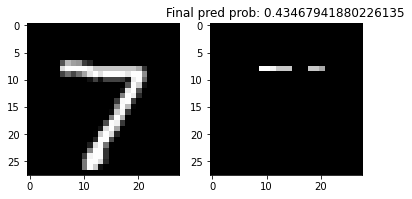

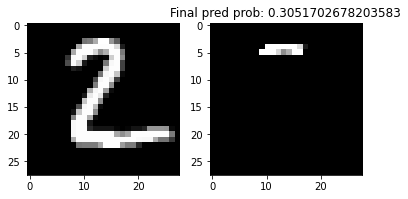

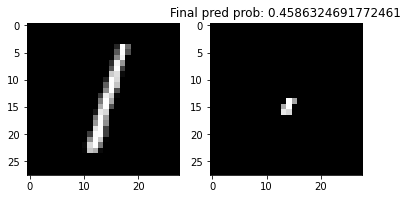

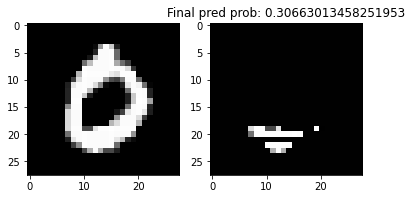

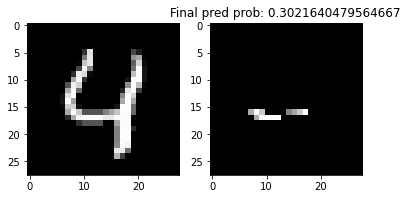

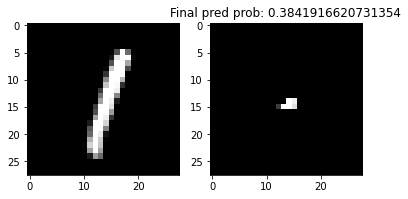

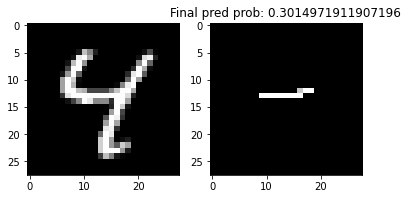

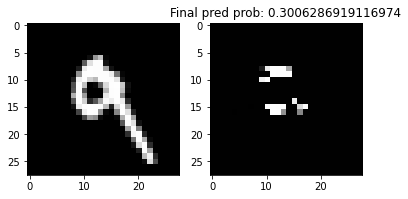

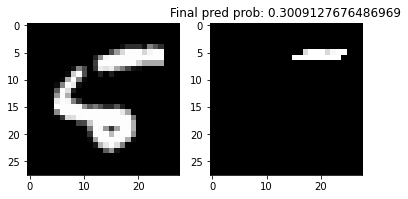

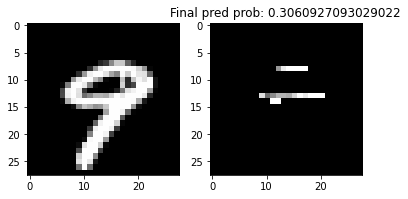

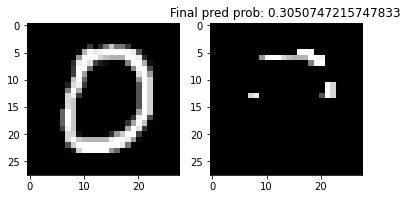

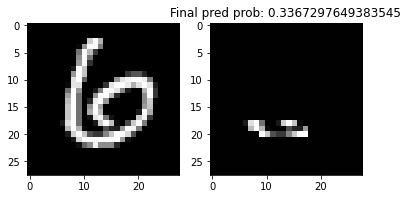

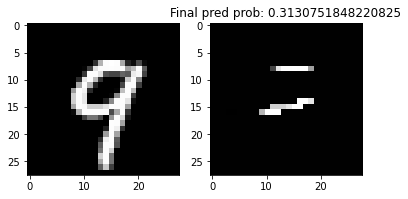

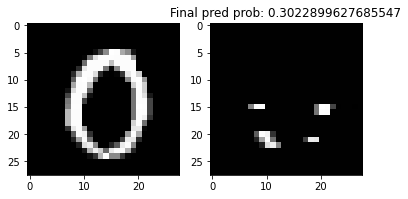

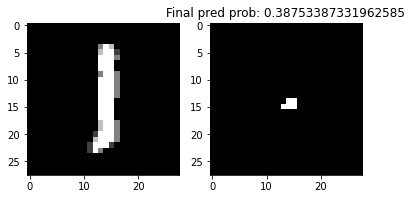

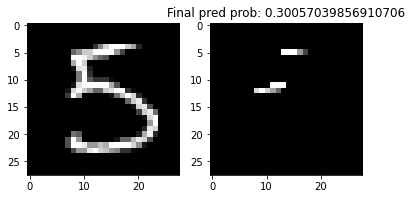

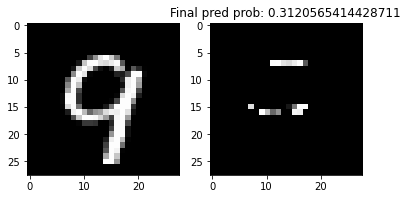

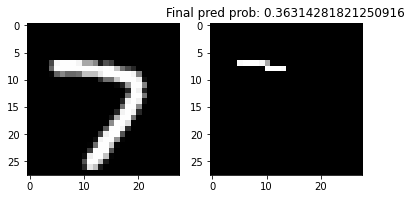

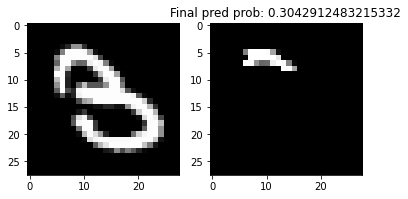

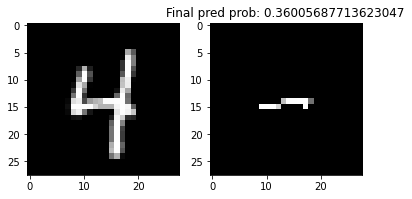

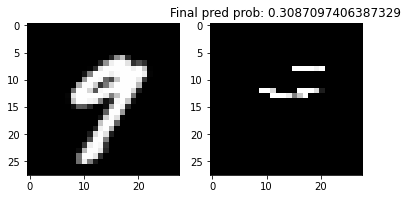

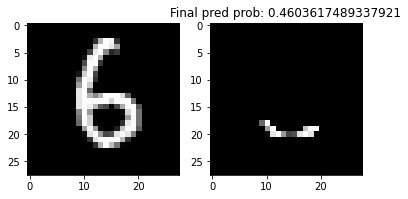

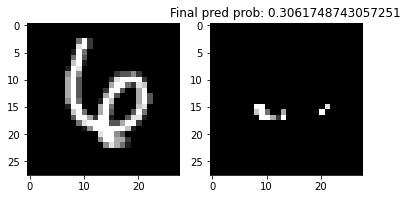

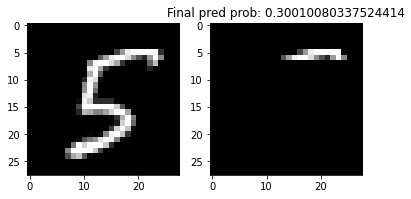

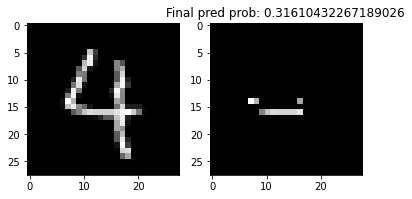

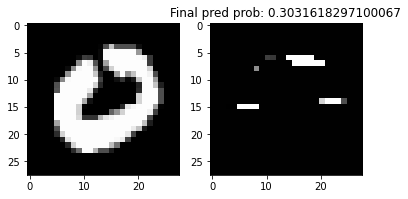

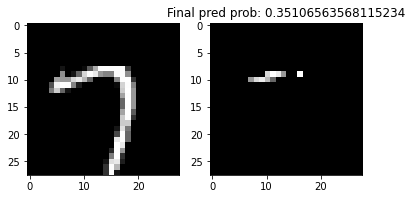

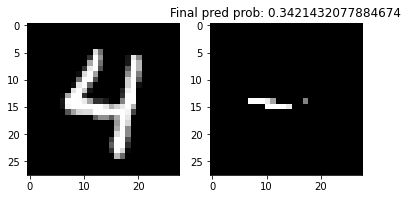

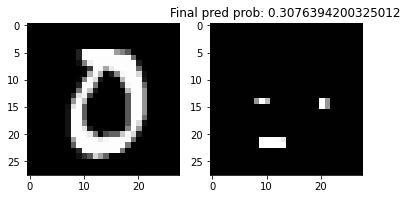

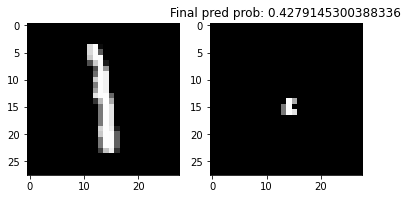

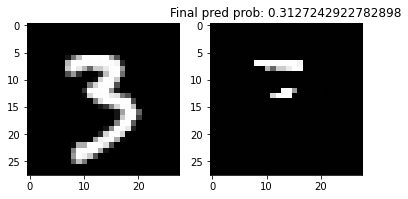

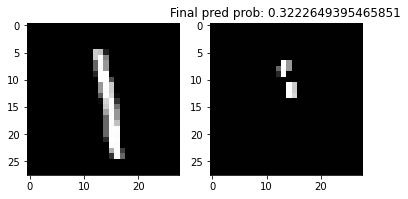

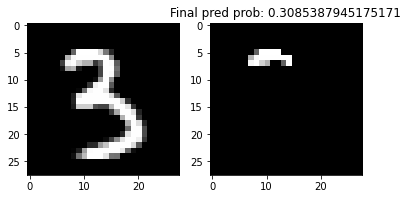

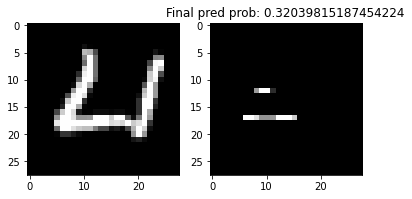

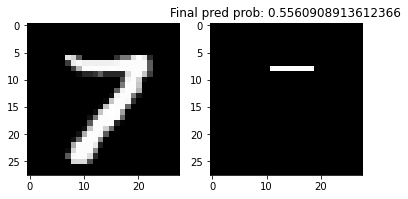

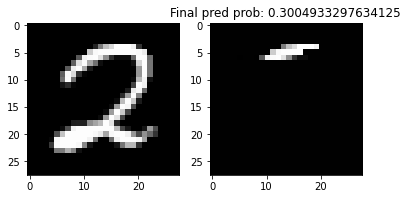

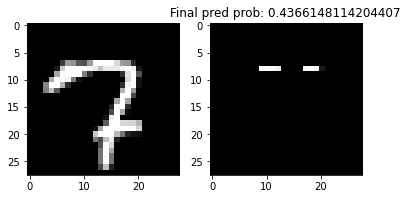

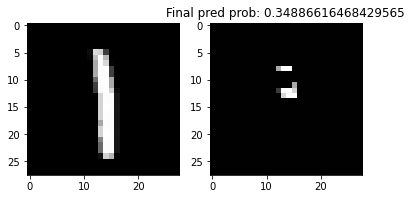

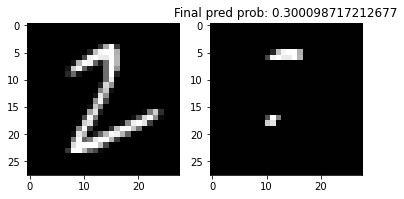

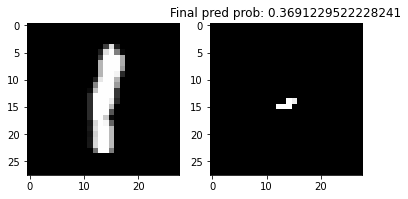

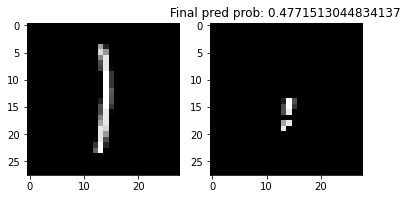

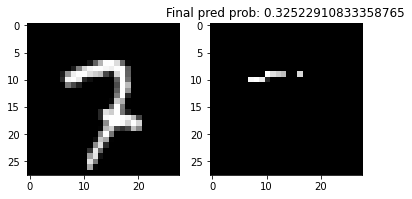

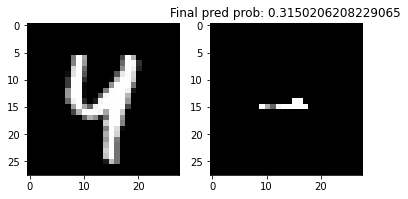

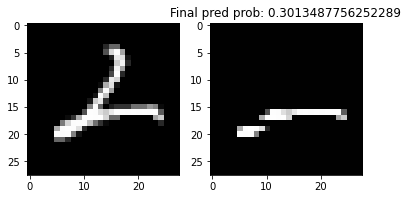

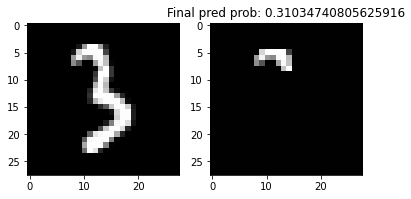

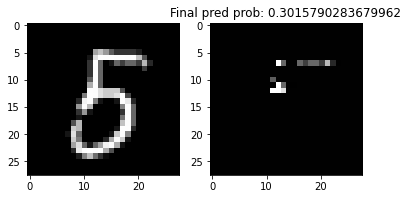

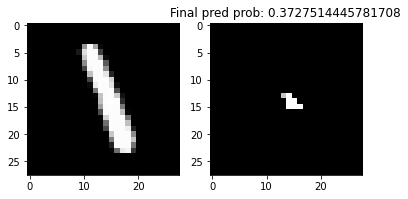

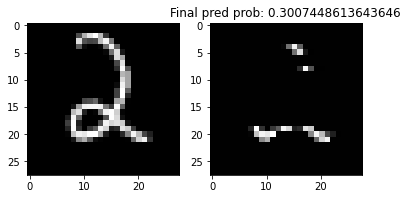

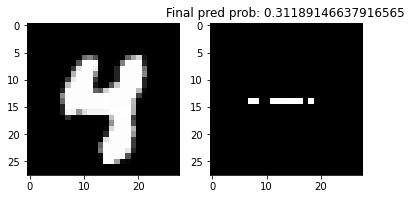

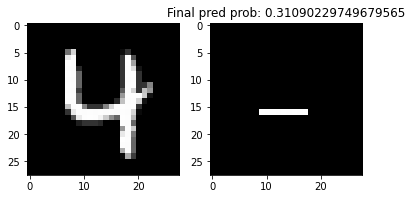

In [20]:
for img_idx in range(0, 50):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    print(img_idx, label)
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.3, img, label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    plt.title("Final pred prob: {}".format(pred_prob))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

    
    


In [ ]:
# for img_idx in range(0, 10):
#     (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
#     if label != 0:
#         continue
#     model.eval()
#     active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["active_neurons"]
#     non_active_neurons_idx = all_alpha_patterns[epsilon_for_pattern][label]["non_active_neurons"]
#     ap = all_alpha_patterns[epsilon_for_pattern][label]["alpha_pattern"]
#     si = all_alpha_patterns[epsilon_for_pattern][label]["stable_idx"]
#     new_extend_img = img[:, None]
#     with torch.no_grad():
#         output = model(new_extend_img.to(device))
#         # TODO: check image pattern
#         same_activation = check_activation(new_extend_img, label, device, active_neurons_idx, non_active_neurons_idx, si, ap)
#         if same_activation:
#             print("same_activation", same_activation)

0 7
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
in the end: 5
1 2
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activation: False
same_activat

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\4039588407.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


same_activation: False


C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\4039588407.py:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


same_activation: False
same_activation: False


KeyboardInterrupt: 

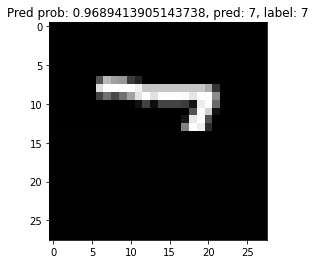

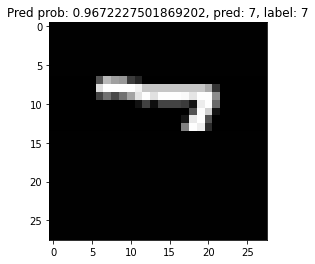

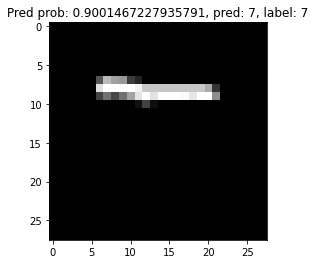

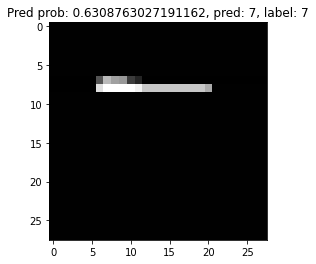

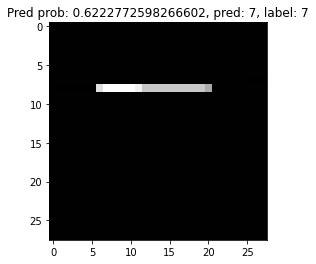

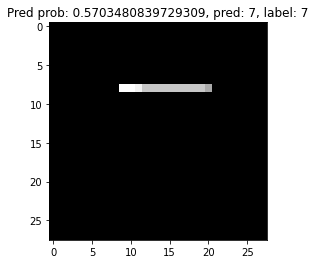

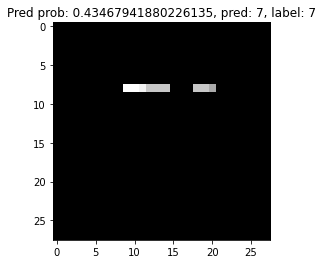

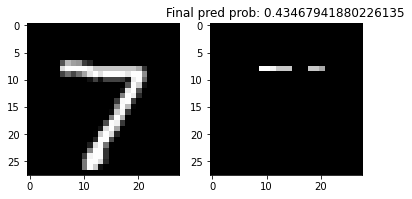

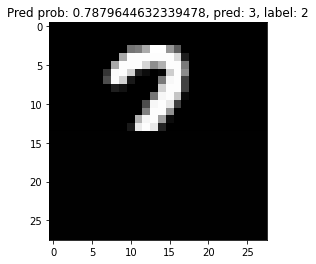

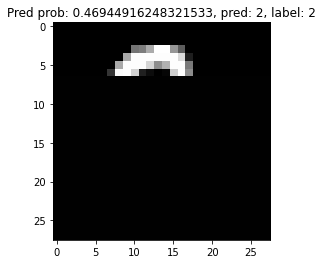

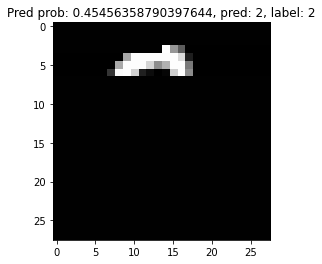

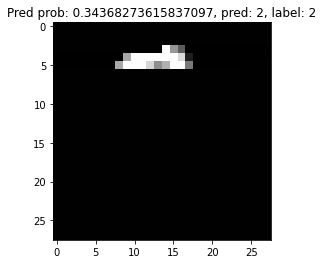

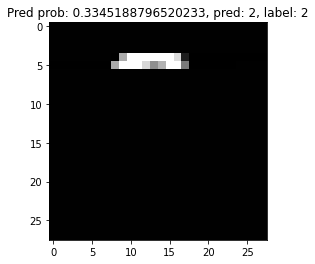

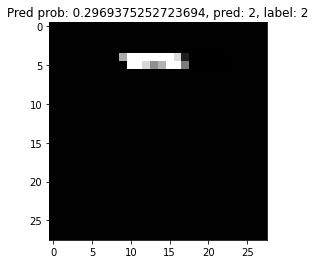

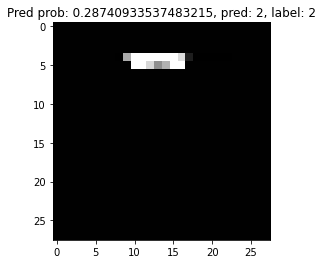

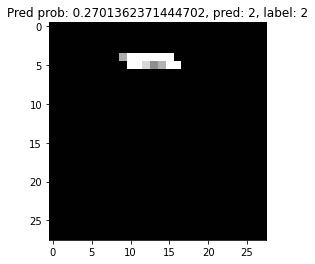

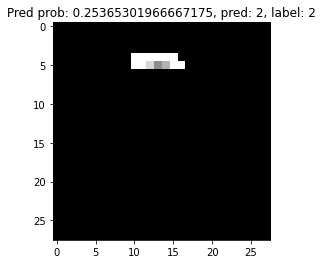

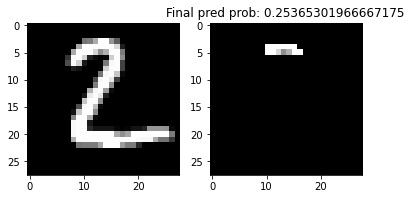

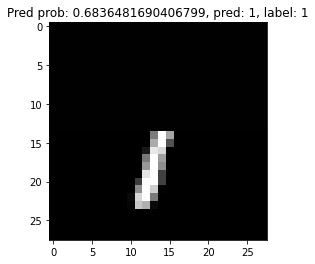

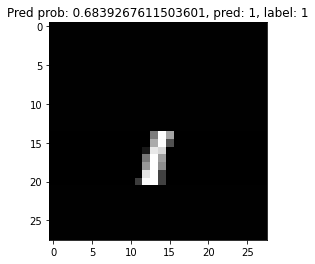

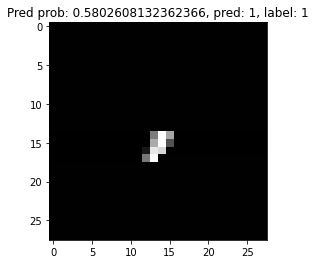

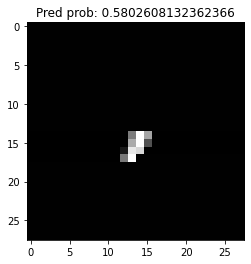

In [28]:
for img_idx in range(0, 50):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    print(img_idx, label)
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.3, img, label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    plt.title("Final pred prob: {}".format(pred_prob))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

# Original Check

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 0.7641921397379913
same activation status ratio for act and noact: 1.0
no act check final activation:  True
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: 2, groud truth 2
same activation status ratio for org and act: 0.8056768558951966
same activation status ratio for act and noact: 1.0
no act check final activation:  True
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the 

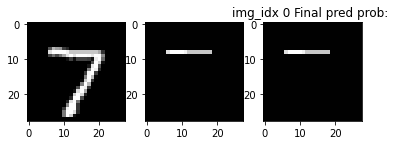

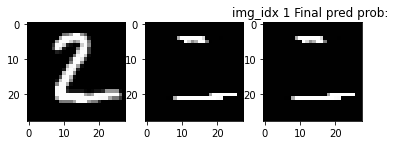

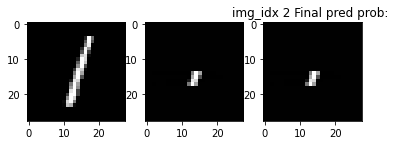

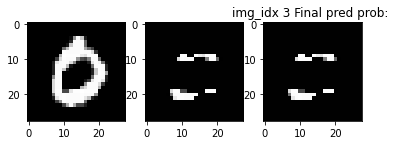

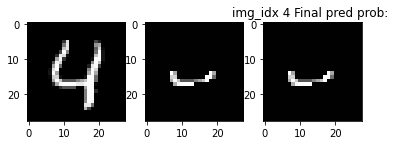

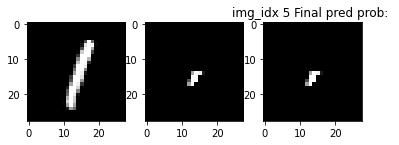

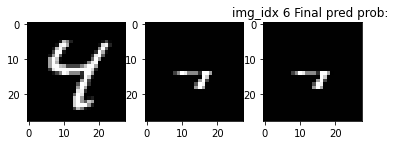

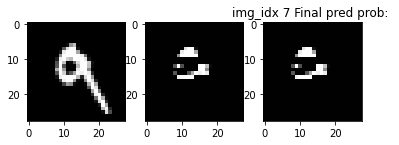

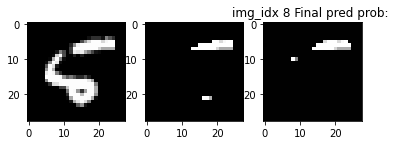

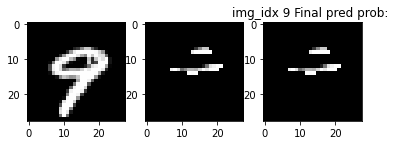

In [9]:
# EPSILON 0.0001
# Original check not random select

for img_idx in range(0, 10):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 7, modified: True
pred prob:  0.6025474667549133

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 0.740174672489083
same activation status ratio for act and noact: 0.8537117903930131
no act check final activation:  False
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: 2, groud truth 2
same activation status ratio for org and act: 0.8056768558951966
same activation status ratio for act and noact: 1.0
no act check final activation:  True
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING WITH ACTIVATION

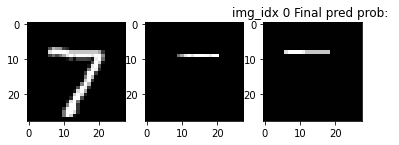

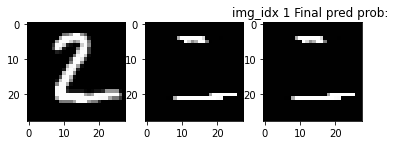

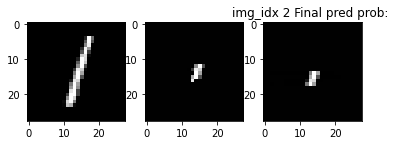

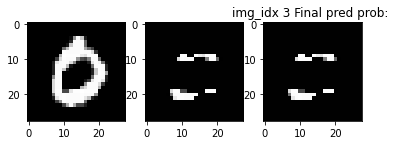

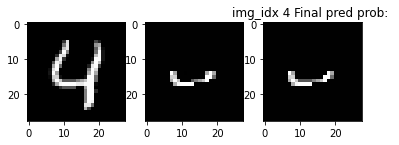

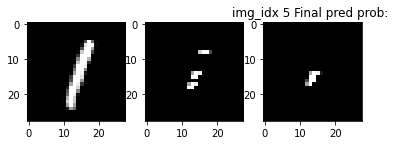

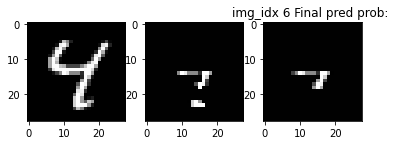

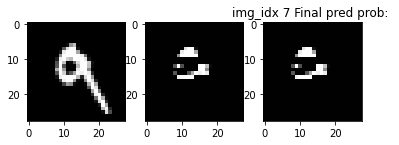

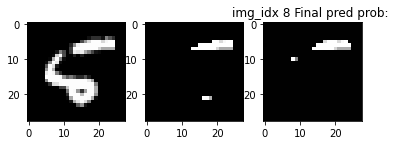

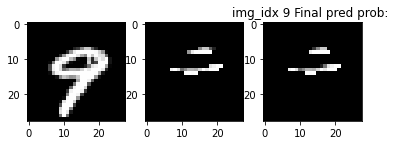

In [10]:
# EPSILON 0.001
# Original check not random select

for img_idx in range(0, 10):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 15, modified: True
pred prob:  0.7762784957885742

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 0.8296943231441049
same activation status ratio for act and noact: 0.7860262008733624
no act check final activation:  False
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 784, modified: False
pred prob:  1

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: None, groud truth 2
same activation status ratio for org and act: 1.0
same activation status ratio for act and noact: 0.8056768558951966
no act check final activation:  False
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING WITH ACTIVATION CHECK:
i

KeyboardInterrupt: 

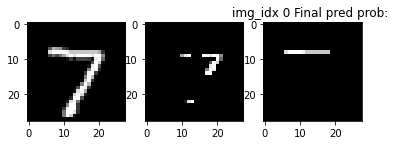

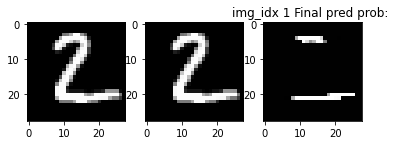

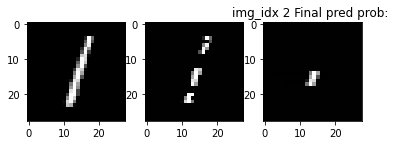

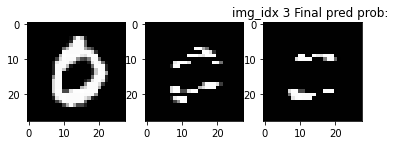

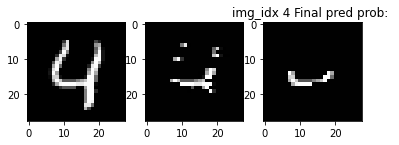

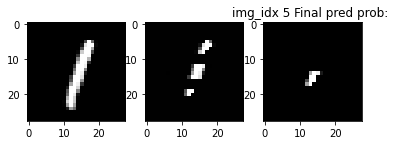

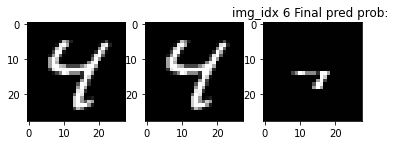

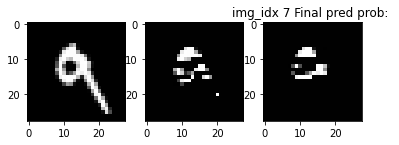

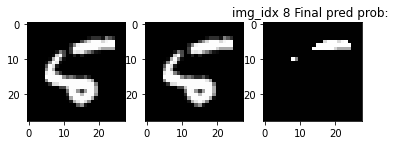

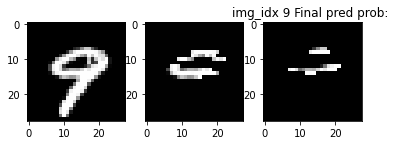

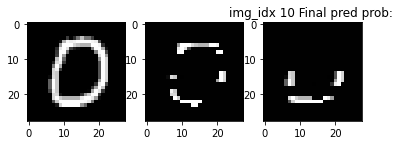

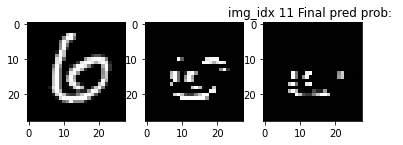

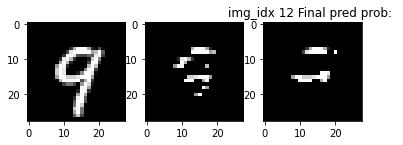

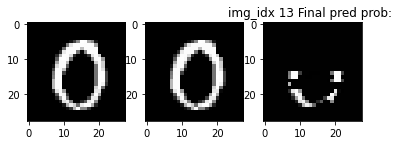

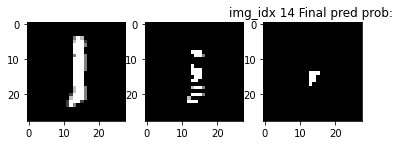

In [98]:
# EPSILON 0.05
# Original check not random select

for img_idx in range(0, 20):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.05
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

# Check with random selected neurons 

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 60, modified: True
pred prob:  0.9923245906829834

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 1.0
same activation status ratio for act and noact: 0.7641921397379913
no act check final activation:  True
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 83, modified: True
pred prob:  0.8255586624145508

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: 2, groud truth 2
same activation status ratio for org and act: 1.0
same activation status ratio for act and noact: 0.8056768558951966
no act check final activation:  True
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the

KeyboardInterrupt: 

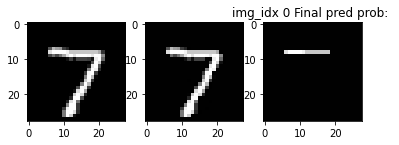

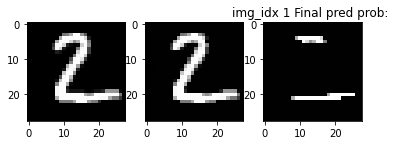

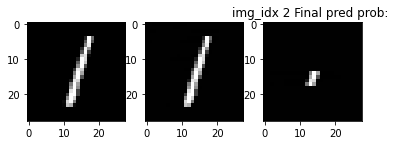

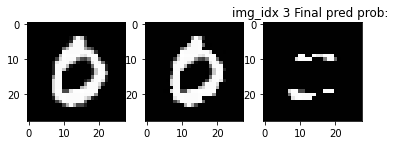

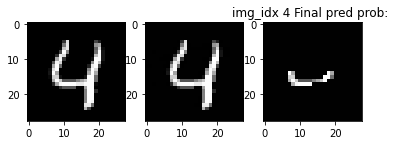

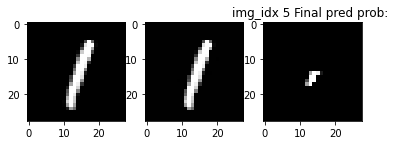

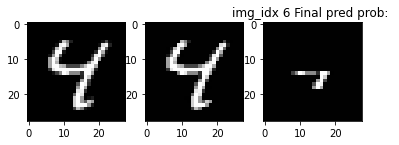

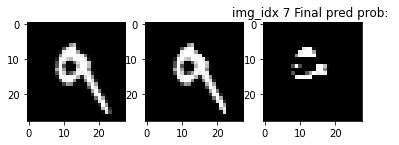

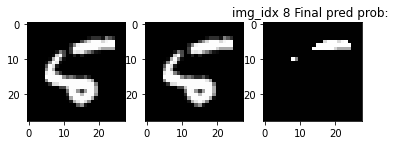

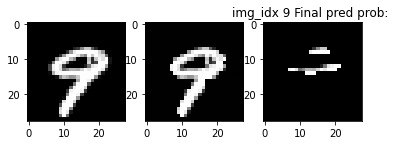

In [93]:
# EPSILON 0.0001

for img_idx in range(0, 20):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 33, modified: True
pred prob:  0.9729995727539062

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 0.9541484716157205
same activation status ratio for act and noact: 0.7925764192139738
no act check final activation:  True
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 39, modified: True
pred prob:  0.6087602972984314

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: 2, groud truth 2
same activation status ratio for org and act: 0.9388646288209607
same activation status ratio for act and noact: 0.8187772925764192
no act check final activation:  True
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING

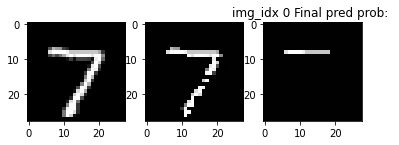

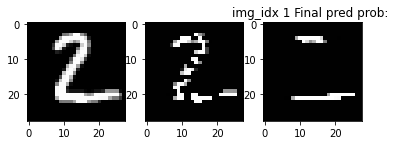

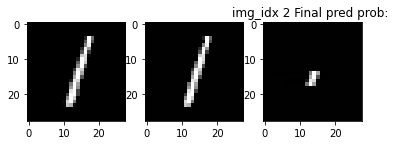

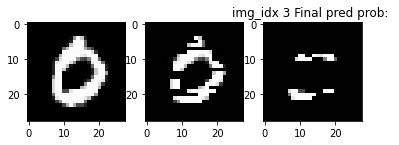

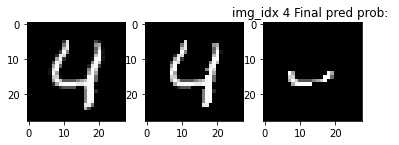

In [96]:
# PORTION =0.3
for img_idx in range(0, 5):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act_portion=0.3)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act_portion=0.3, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

img idex:  0 img label:  7 orginal pred:  7
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 50, modified: True
pred prob:  0.9878062605857849

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 8, modified: True
pred prob:  0.6032127141952515

orig pred: 7, after prediction: 7, groud truth 7
same activation status ratio for org and act: 0.9847161572052402
same activation status ratio for act and noact: 0.7620087336244541
no act check final activation:  True
img idex:  1 img label:  2 orginal pred:  2
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 66, modified: True
pred prob:  0.71992427110672

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 21, modified: True
pred prob:  0.6047056317329407

orig pred: 2, after prediction: 2, groud truth 2
same activation status ratio for org and act: 0.982532751091703
same activation status ratio for act and noact: 0.8056768558951966
no act check final activation:  True
img idex:  2 img label:  1 orginal pred:  1
DELTA DEBUGGING WI

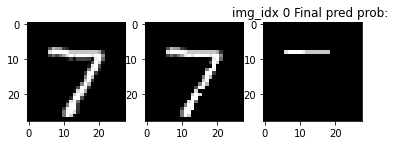

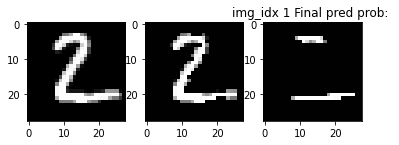

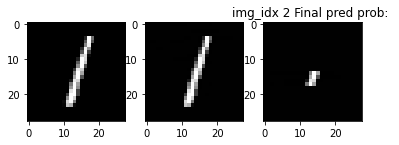

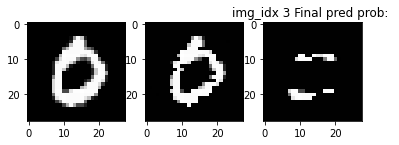

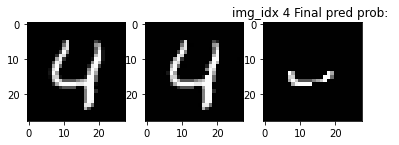

In [95]:
# PORTION =0.5
for img_idx in range(0, 5):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
        
    print("img idex: ", img_idx, "img label: ", label, "orginal pred: ", org_pred)
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act_portion=0.5)
    print("pred prob: ", pred_prob)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, check_act_portion=0.5, check_act = False)
    print("pred prob: ", noact_pred_prob)
    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
#     assert org_act_checking.sum() == len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
#     assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, ""))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

# Others

img idex:  100 img label:  6
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 19

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 18

orig pred: 6, after prediction: 6, groud truth 6
same activation status ratio for org and act: 0.7903930131004366
same activation status ratio for act and noact: 0.980349344978166
no act check final activation:  True
img idex:  101 img label:  0
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 32

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 32

orig pred: 0, after prediction: 0, groud truth 0
same activation status ratio for org and act: 0.7532751091703057
same activation status ratio for act and noact: 1.0
no act check final activation:  True
img idex:  102 img label:  5
DELTA DEBUGGING WITH ACTIVATION CHECK:
in the end: 12

DELTA DEBUGGING WITH =NO= ACTIVATION CHECK:
in the end: 12

orig pred: 5, after prediction: 5, groud truth 5
same activation status ratio for org and act: 0.7903930131004366
same activation status ratio for a

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_53720\3894096118.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,3)


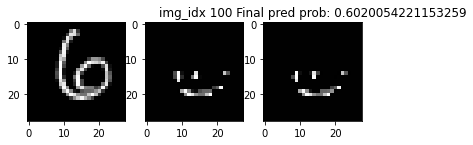

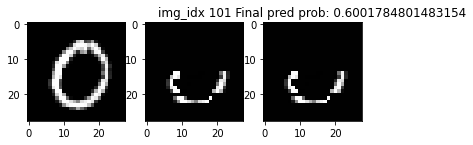

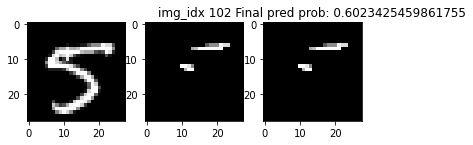

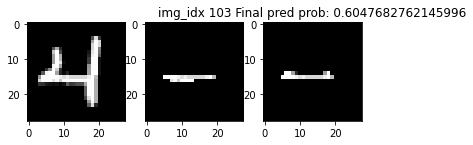

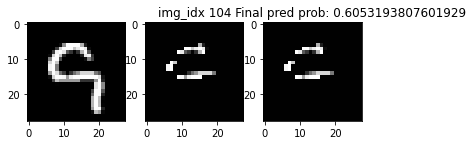

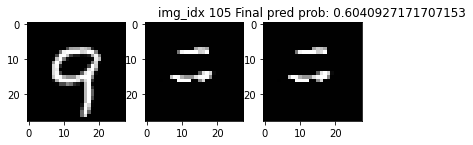

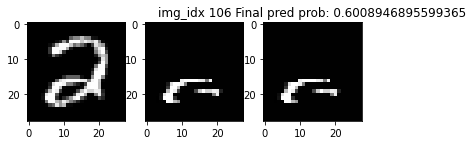

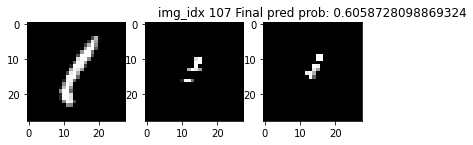

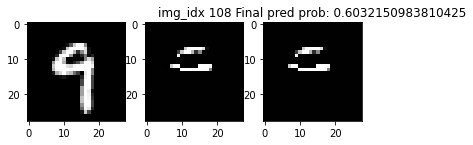

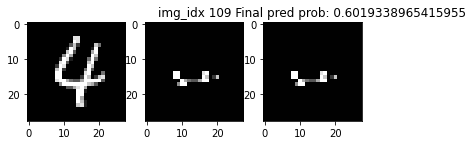

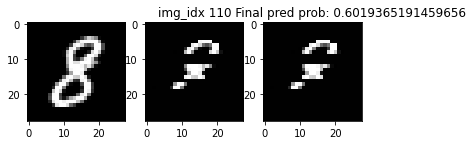

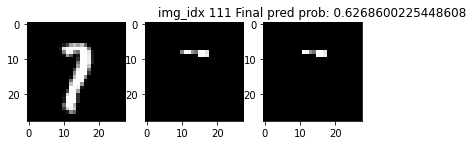

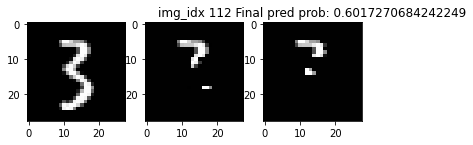

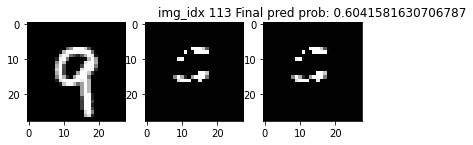

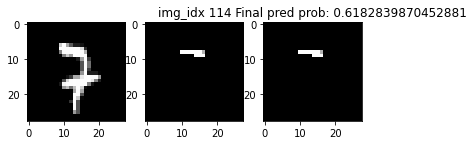

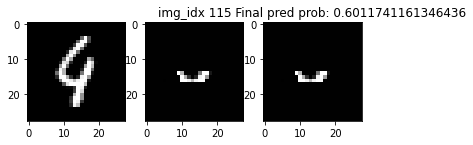

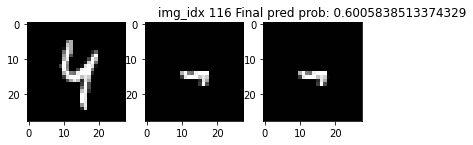

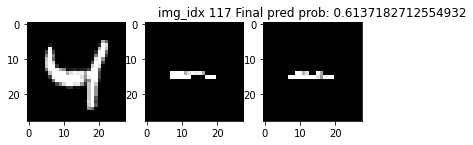

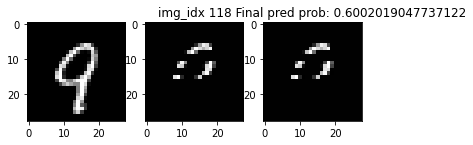

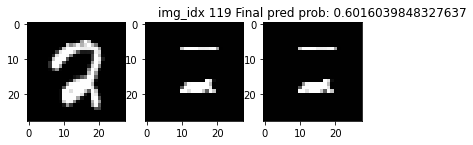

In [79]:

for img_idx in range(100, 120):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    print("img idex: ", img_idx, "img label: ", label)
    
    ep = 0.0001
    
    stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
    active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
    non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]
    
    data = img[None, :]
    org_img_pattern = model.get_pattern(data, layers, device, flatten = True)
    
    with torch.no_grad():
        output = model(data.to(device))
        org_pred = torch.argmax(output).item()
    
    print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep)
    print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
    noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, False)

    
    data_after = pred_img[None, :]
    aft_img_pattern = model.get_pattern(data_after, layers, device, flatten = True)
    
    
    noact_data_after = noact_pred_img[None, :]
    noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
    noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)

    
    org_act_checking = org_img_pattern == aft_img_pattern
    org_noact_checking = org_img_pattern == noact_aft_img_pattern
    act_noact_checking = aft_img_pattern == noact_aft_img_pattern
    
    
     
    print('')
    
    
#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
    print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
    print("same activation status ratio for org and act:", org_act_checking.sum()/len(org_act_checking[0]) )
    print("same activation status ratio for act and noact:", act_noact_checking.sum()/len(act_noact_checking[0]) )
    
    print("no act check final activation: ", noact_check_activation)
    assert org_act_checking.sum() != len(org_act_checking[0])
#     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
#     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
    assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
#     plt.title("Final pred prob: {}".format(pred_prob))
    plt.title("img_idx {} Final pred prob: {}".format(img_idx, pred_prob))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

In [78]:

img_indices = [0,1]
img_subset = torch.utils.data.Subset(dataset2, img_indices)
(img1, label1) = img_subset[0]
(img2, label2) = img_subset[1]

#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
print("img idex: ", img_indices, "img label: ", label1, label2)

ep = 0.0001

# stable_idx = all_alpha_patterns[ep][label]["stable_idx"]
# active_neurons_idx = all_alpha_patterns[ep][label]["active_neurons"]
# non_active_neurons_idx = all_alpha_patterns[ep][label]["non_active_neurons"]

data1 = img1[None, :]
img1_pattern = model.get_pattern(data1, layers, device, flatten = True)

data2 = img2[None, :]
img2_pattern = model.get_pattern(data2, layers, device, flatten = True)

# with torch.no_grad():
#     output = model(data.to(device))
#     org_pred = torch.argmax(output).item()

# print("DELTA DEBUGGING WITH ACTIVATION CHECK:")
pred_img1, pred_class1, pred_prob1 = delta_debugging_general_new(img_eraser, model, 0.6, img1, label1, ep)
pred_img2, pred_class2, pred_prob2 = delta_debugging_general_new(img_eraser, model, 0.6, img2, label2, ep)
# print("\nDELTA DEBUGGING WITH =NO= ACTIVATION CHECK:")
# noact_pred_img, noact_pred_class, noact_pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, ep, False)


data1_after = pred_img1[None, :]
aft_img1_pattern = model.get_pattern(data1_after, layers, device, flatten = True)

data2_after = pred_img2[None, :]
aft_img2_pattern = model.get_pattern(data2_after, layers, device, flatten = True)



# noact_data_after = noact_pred_img[None, :]
# noact_aft_img_pattern = model.get_pattern(noact_data_after, layers, device, flatten = True)
# noact_check_activation = check_activation(noact_data_after, label, device, active_neurons_idx, non_active_neurons_idx)


org_checking = img1_pattern == img2_pattern
aft_checking = aft_img1_pattern == aft_img2_pattern
print('')


#     print("org pattern", org_img_pattern)
#     print("aft pattern", aft_img_pattern)
# print("orig pred: {}, after prediction: {}, groud truth {}".format(org_pred, pred_class, label))
#     print("check all neuron pattern", org_act_checking)
print("same activation status ratio for org:", org_checking.sum()/len(org_checking[0]) )
print("same activation status ratio for after:", aft_checking.sum()/len(aft_checking[0]) )

# print("no act check final activation: ", noact_check_activation)
# assert org_act_checking.sum() != len(org_act_checking[0])
# #     print("check stable neuron pattern before", org_img_pattern[:, stable_idx])
# #     print("check stable neuron pattern after", aft_img_pattern[:, stable_idx])
# assert org_act_checking[:, stable_idx].sum() == len(stable_idx) - (org_pred != label)
print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

# figure = plt.figure()
# f, axarr = plt.subplots(1,3)
# axarr[0].imshow(img.reshape(28, 28), cmap="gray")
# axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
# axarr[2].imshow(noact_pred_img.reshape(28, 28), cmap="gray")
# #     plt.title("Final pred prob: {}".format(pred_prob))
# plt.title("img_idx {} Final pred prob: {}".format(img_idx, pred_prob))
# plt.savefig(IMG_RESULT.format(label, img_idx))
# plt.close(figure)

img idex:  [0, 1] img label:  7 2
in the end: 8
in the end: 21

same activation status ratio for org: 0.6703056768558951
same activation status ratio for after: 0.5982532751091703


4 4
can't go 6 4
in the end: 4


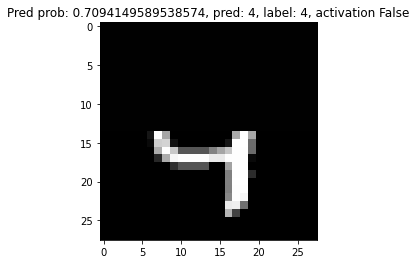

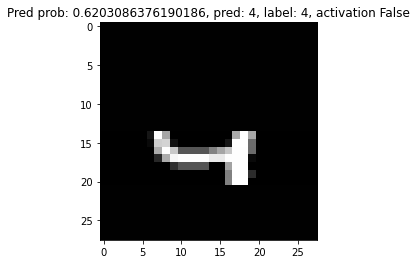

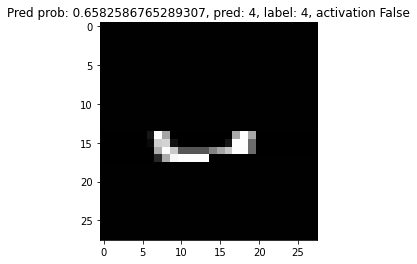

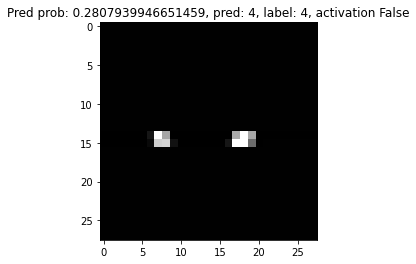

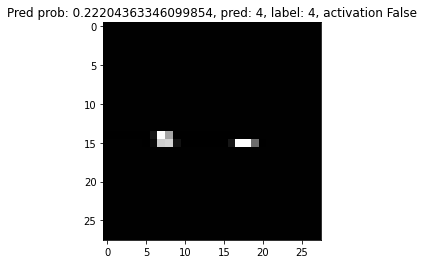

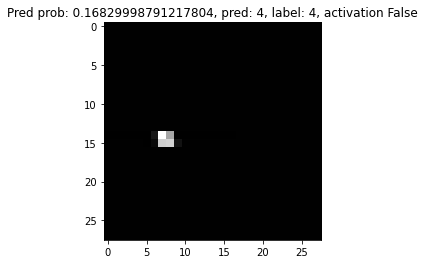

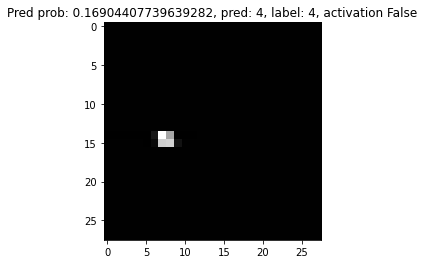

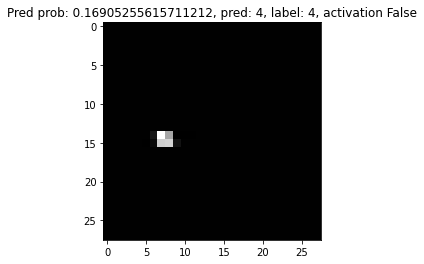

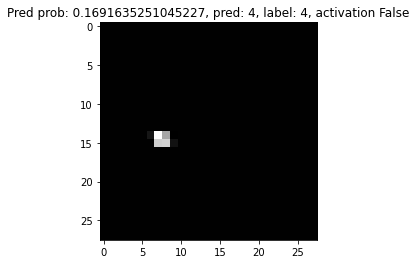

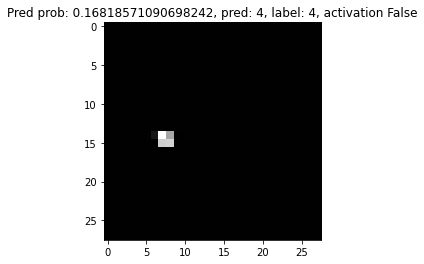

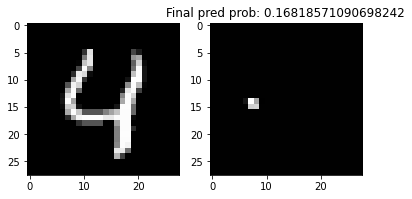

In [45]:
# DIFFERENT EPOSILON


for img_idx in range(4, 5):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    
#     if label != 0:
#         continue
#     plt.figure()
#     plt.imshow(img.reshape(28, 28), cmap="gray")
    print(img_idx, label)
    pred_img, pred_class, pred_prob = delta_debugging_general_new(img_eraser, model, 0.6, img, label, 0.05)
    print("===========")
# #     plt.figure()
# #     plt.imshow(pred_img.reshape(28, 28), cmap="gray")

    figure = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.reshape(28, 28), cmap="gray")
    axarr[1].imshow(pred_img.reshape(28, 28), cmap="gray")
    plt.title("Final pred prob: {}".format(pred_prob))
    plt.savefig(IMG_RESULT.format(label, img_idx))
    plt.close(figure)

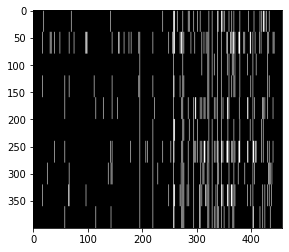

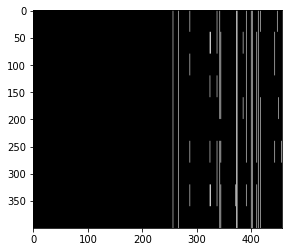

In [73]:
alpha_patterns = all_alpha_patterns[0.0001]

a_neurons = np.zeros((400, 458))
n_neurons = np.zeros((400, 458))
for l in range(10):
    
    
    stable_idx = alpha_patterns[l]["stable_idx"]
    active_neurons_idx = alpha_patterns[l]["active_neurons"]
    non_active_neurons_idx = alpha_patterns[l]["non_active_neurons"]
    
    a_neurons[l*40: (l+1)*40, active_neurons_idx] = 1
    n_neurons[l*40: (l+1)*40, non_active_neurons_idx] =1

figure = plt.figure()
plt.imshow(a_neurons, cmap="gray")

figure = plt.figure()
plt.imshow(n_neurons, cmap="gray")
# plt.close(figure)

In [76]:
debug = True
if debug:
    alpha_patterns = all_alpha_patterns[0.0001]
    overlap = set(alpha_patterns[0]["stable_idx"])
    for l1 in range(0,10):
        overlap = set(alpha_patterns[l1]["stable_idx"]) & overlap
    
    print(f"overlap neurons {overlap} contains {len(overlap)} neurons " )
                    
        

overlap neurons {257, 258, 323, 267, 401, 275, 403, 339, 374, 375, 346, 414} contains 12 neurons 
